In [1]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.population_model as pop
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import lbg_forecast.priors_gp_dust as gpdp
import scipy as sc

In [2]:
nruns=1
run='test_nag'
extra=True
spsp = []
selected_spsp = []
photometry = []
nzs = []
sparams = []
ndens = []
for i in range(nruns):
    spsp.append(np.load("sps_parameter_samples/sps_"+run+"_"+str(i)+".npy"))
    selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    photometry.append(np.load("photo_samples/photo_"+run+"_"+str(i)+".npy"))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))
    sparams.append(np.load("sps_parameter_samples/sparams_"+run+"_"+str(i)+".npy"))
    ndens.append(np.load("nz_samples/n_detected_"+run+"_"+str(i)+".npy"))

spsp = np.vstack(spsp)
selected_spsp = np.vstack(selected_spsp)
photometry = np.vstack(photometry)
nzs = np.vstack(nzs)
sparams = np.vstack(sparams)
ndens = np.vstack(ndens)
print(spsp.shape, selected_spsp.shape, photometry.shape, nzs.shape, sparams.shape, ndens.shape)

(8, 200000, 17) (8, 3) (8, 200000, 5) (8, 3) (8, 3, 100) (8, 3)


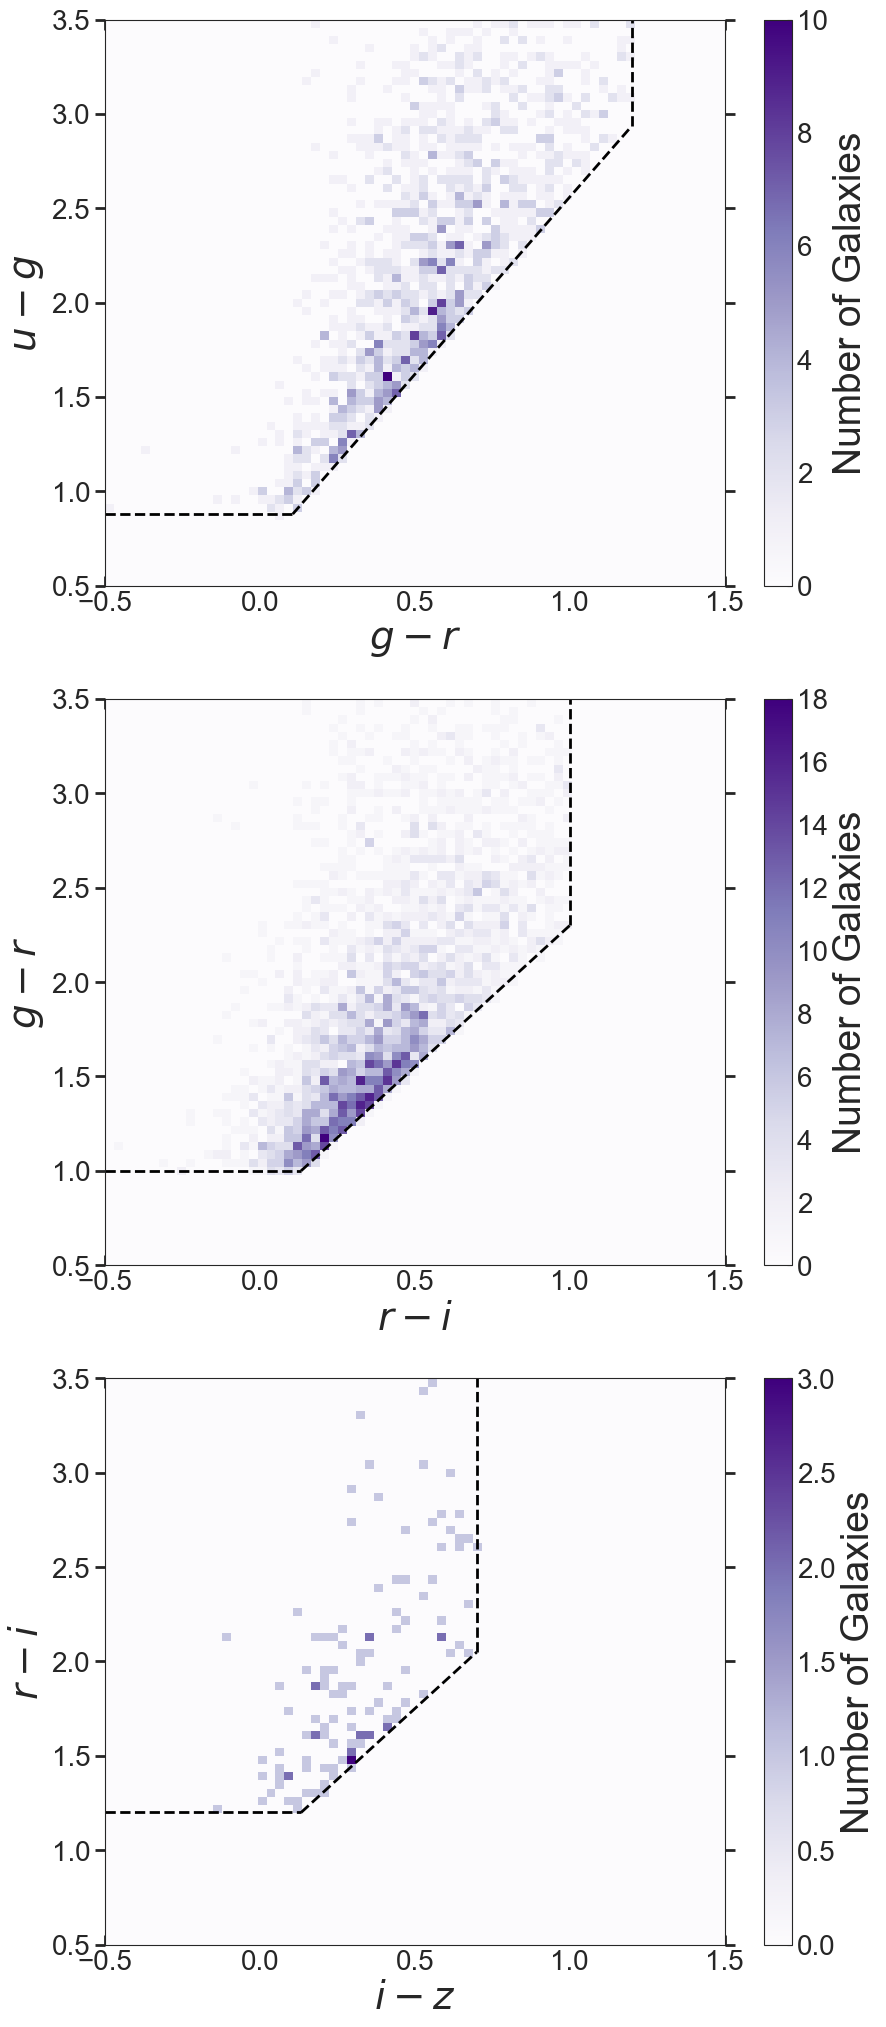

In [3]:
run_no=0

if(extra):

    colour_labels = ['$u-g$', '$g-r$', '$r-i$', '$i-z$']
    binsx = np.linspace(-0.5, 1.5, 70)
    binsy = np.linspace(0.5, 3.5, 70)
    bins2d = [binsx, binsy]
    f, ax = plt.subplots(3, 1, figsize=(10, 25))
    lbg_colours = np.load("nz_samples/c_"+run+"_"+str(run_no)+".npy", allow_pickle=True)
    for i in range(3):
        #cs = []
        #for real in lbg_colours[:, i]:
        #    cs.append(np.squeeze(real))

        #dropout_colours = np.vstack(cs)
        dropout_colours = np.squeeze(lbg_colours[0, i])
        histogram = ax[i].hist2d(dropout_colours[:, i+1], dropout_colours[:, i], bins=bins2d, density=False, cmap='Purples')
        fs=28
        ax[i].set_xlabel(colour_labels[i+1], fontsize=fs)
        ax[i].set_ylabel(colour_labels[i], fontsize=fs)
        #ax[i].set_xticks(np.arange(-0.5, 2.0, 0.5))
        #ax[i].set_yticks(np.arange(0.5, 4.0, 0.5))
        ax[i].grid(visible=True, alpha=0.2)
        
        lw=2
        ls='--'
        if(i==0):
            ax[i].plot([-0.5, (0.88-0.68)/1.88], [0.88, 0.88], c='k', lw=lw, ls=ls)
            ax[i].plot([(0.88-0.68)/1.88, 1.2], [0.88, 1.2*1.88+0.68], c='k', lw=lw, ls=ls)
            ax[i].plot([1.2, 1.2], [1.2*1.88+0.68, 3.5], c='k', lw=lw, ls=ls)

        if(i==1):
            ax[i].plot([-0.5, (1.0-0.8)/1.5], [1.0, 1.0], c='k', lw=lw, ls=ls)
            ax[i].plot([(1.0-0.8)/1.5, 1.0], [1.0, 1.0*1.5+0.8], c='k', lw=lw, ls=ls)
            ax[i].plot([1.0, 1.0], [1.0*1.5+0.8, 3.5], c='k', lw=lw, ls=ls)

        if(i==2):
            ax[i].plot([-0.5, (1.2-1.0)/1.5], [1.2, 1.2], c='k', lw=lw, ls=ls)
            ax[i].plot([(1.2-1.0)/1.5, 0.7], [1.2, 0.7*1.5+1.0], c='k', lw=lw, ls=ls)
            ax[i].plot([0.7, 0.7], [0.7*1.5+1.0, 3.5], c='k', lw=lw, ls=ls)

        cbar =plt.colorbar(histogram[-1], orientation='vertical')
        cbar.set_label(label='Number of Galaxies', size=fs)
        cbar.ax.tick_params(labelsize=20)

        ax[i].tick_params('x', labelsize=20, direction='in', width=2, size=7, bottom=True)
        ax[i].tick_params('y', labelsize=20, direction='out', width=2, size=7, left=True)
        #ax[i].minorticks_on()
        #ax[i].tick_params(axis='x', which='minor', direction='in', size=5, top=True)
        #ax[i].tick_params(axis='y', which='minor', direction='in', size=5, right=True)


In [4]:
percentile=84
mean = np.mean(ndens, axis=0)
std =  np.std(ndens, axis=0)
errl = np.percentile(ndens, 100-percentile, axis=0)
errh = np.percentile(ndens, percentile, axis=0)

print("u-dropout number density (std): ",mean[0],"+/-",std[0],"deg-2")
print("g-dropout number density (std): ",mean[1],"+/-",std[1],"deg-2")
print("r-dropout number density (std): ",mean[2],"+/-",std[2],"deg-2")

u-dropout number density (std):  2950.1649153074122 +/- 331.98765601272237 deg-2
g-dropout number density (std):  7629.272251730936 +/- 366.47977642322525 deg-2
r-dropout number density (std):  379.4801034091736 +/- 64.10617968930784 deg-2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


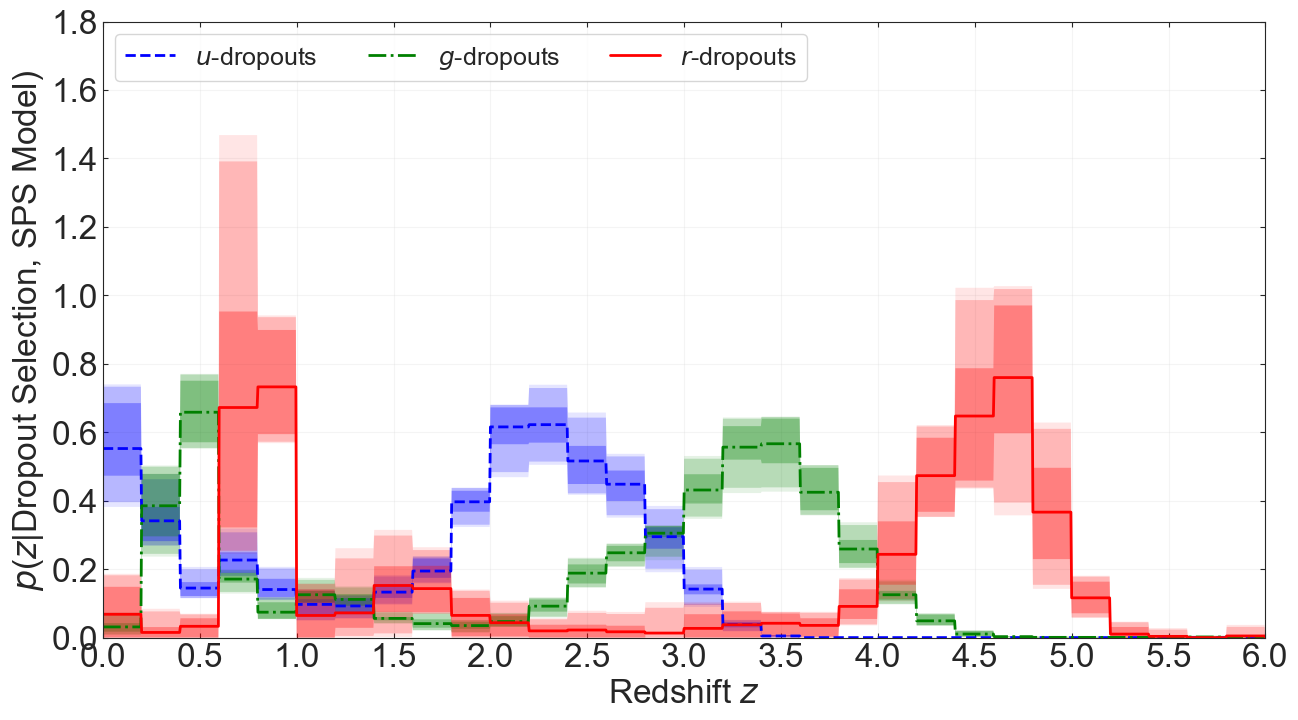

In [5]:
def plot_nzs(axes, nzs, mean, density, a, p, **kwargs):

    ndropouts = 3

    percentile=p

    bin_step = 0.2
    bin_start = 0
    bin_end = 7

    bins = np.arange(bin_start, bin_end, bin_step)
    colours = ['blue', 'green', 'red']
    labels = ['$u$-dropouts', "$g$-dropouts", "$r$-dropouts"]
    lss=['--', '-.', '-']


    samples=50
    grid = np.arange(bin_start, bin_end-bin_step, bin_step/samples)

    for drop in range(ndropouts):

        values = []
        for ind in range(nzs.shape[0]):
            hist = np.histogram(nzs[ind][drop], density=density, bins=bins)
            oversampled_values = np.repeat(hist[0], samples)
            values.append(oversampled_values)

        values = np.vstack((np.array(values)))
        mean_at_grid_point = np.mean(values, axis=0)
        percentile_at_point = np.percentile(values, [100-percentile, 50, percentile], axis=0)
        if(mean):
            axes.plot(grid, mean_at_grid_point, c=colours[drop], **kwargs, label=labels[drop], ls=lss[drop], lw=2)
        axes.fill_between(grid, percentile_at_point[0, :], percentile_at_point[2, :], alpha=a, color=colours[drop], lw=0)

    axes.legend(fontsize=18, ncol=3, loc='upper left')
    axes.set_xlabel("Redshift $z$", fontsize=24)
    axes.set_ylabel("$p$($z$|Dropout Selection, SPS Model)", fontsize=24)
    axes.set_xticks(np.arange(0, 7, 0.5))
    axes.tick_params('x', labelsize=24)
    axes.tick_params('y', labelsize=24)
    axes.grid(alpha=0.2)
    axes.set_xlim(0, 6)
    axes.set_ylim(0, 1.8)


density=True
fig1, axes = plt.subplots(1, 1, figsize=(15,8), sharex=False, sharey=False)
plot_nzs(axes, nzs, mean=False, density=density, ls='--', a=0.1, p=99.7)
plot_nzs(axes, nzs, mean=False, density=density, ls='--', a=0.2, p=97.5)
plot_nzs(axes, nzs, mean=True, density=density, a=0.3, p=84)

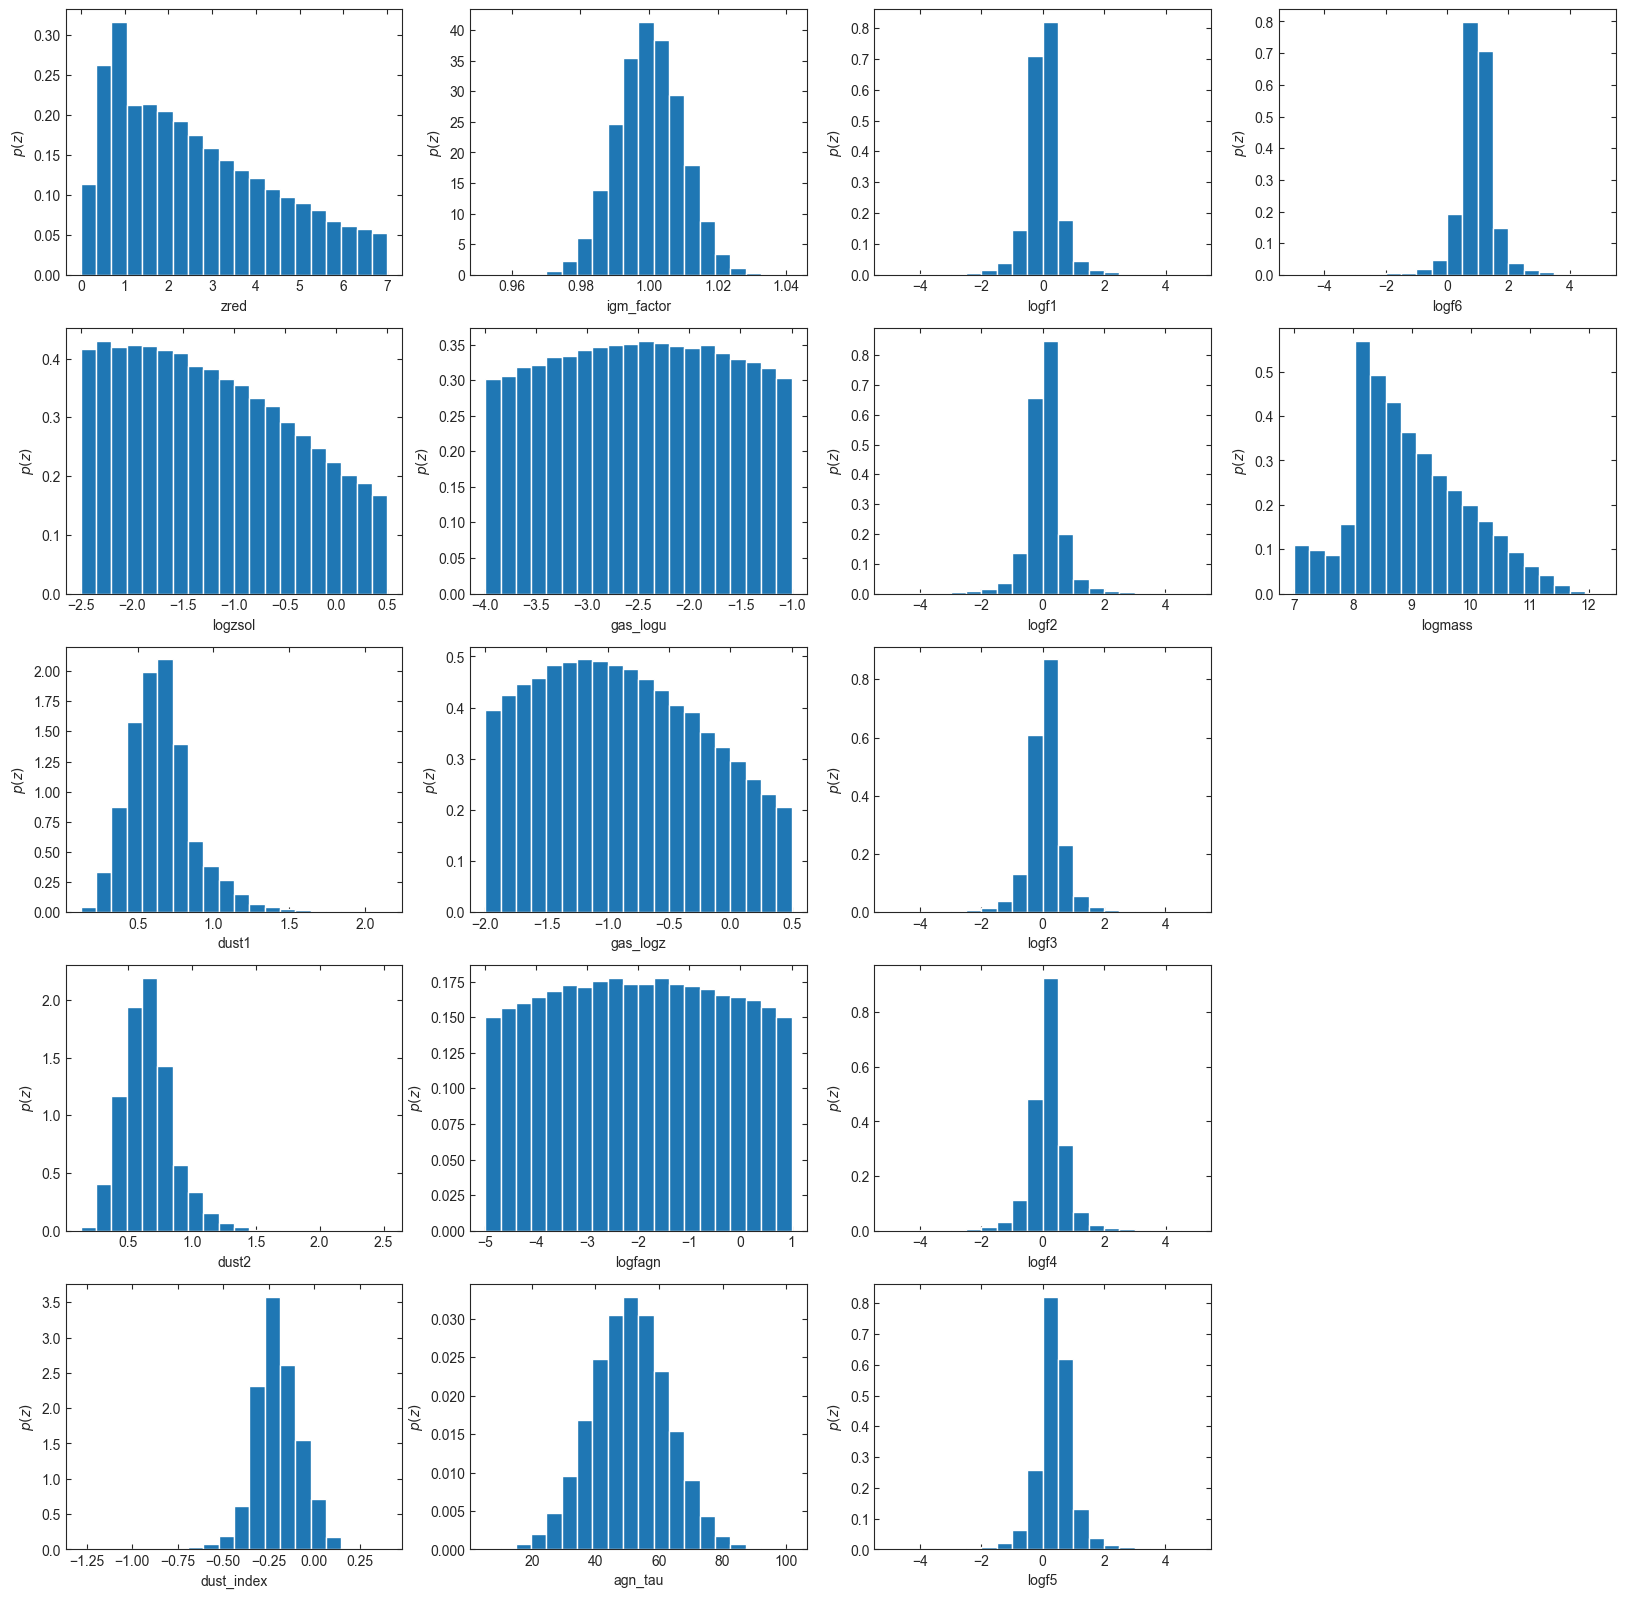

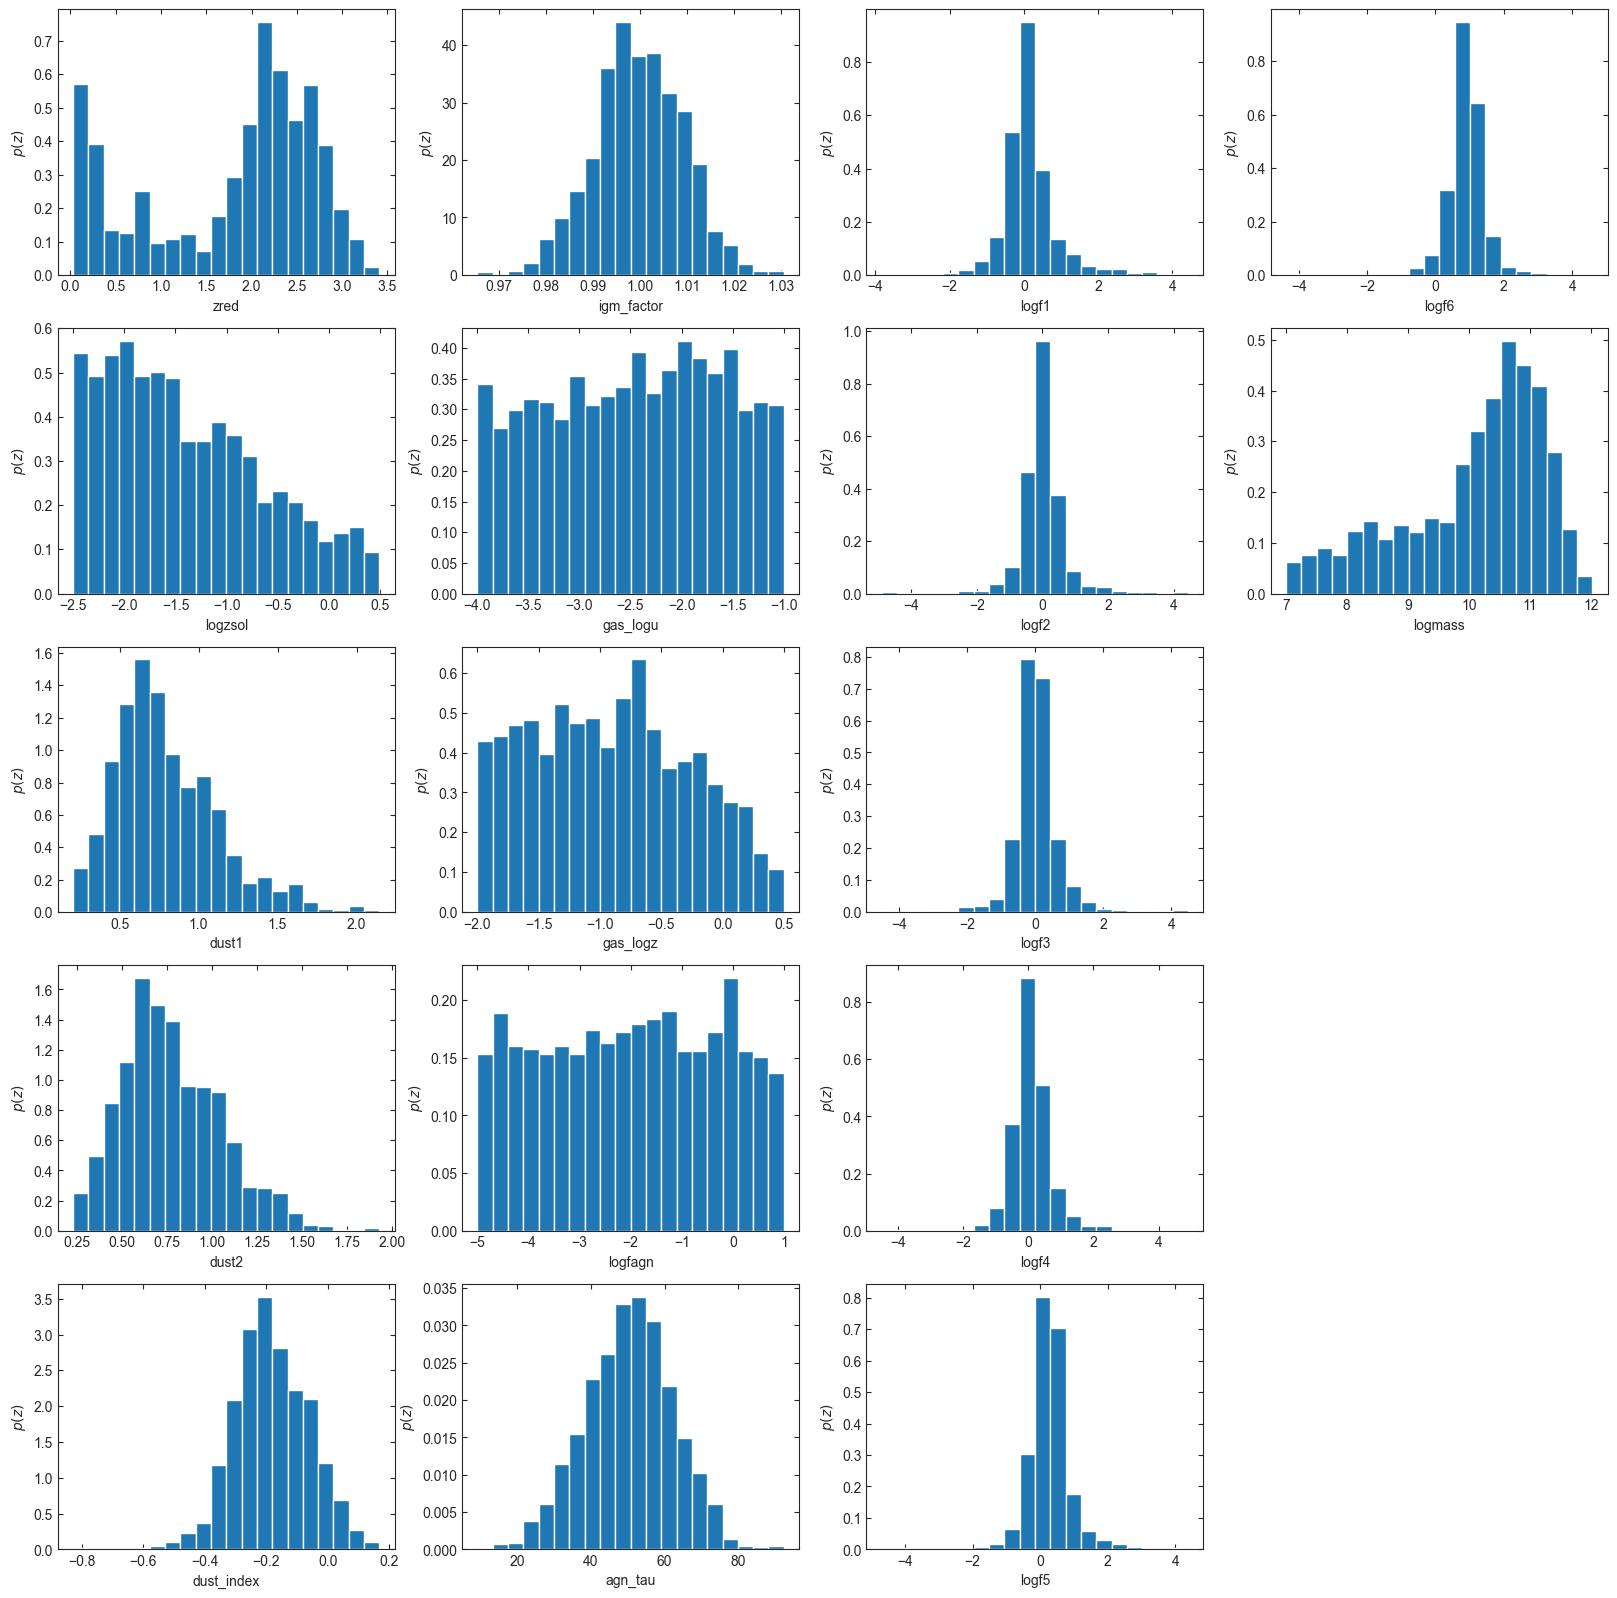

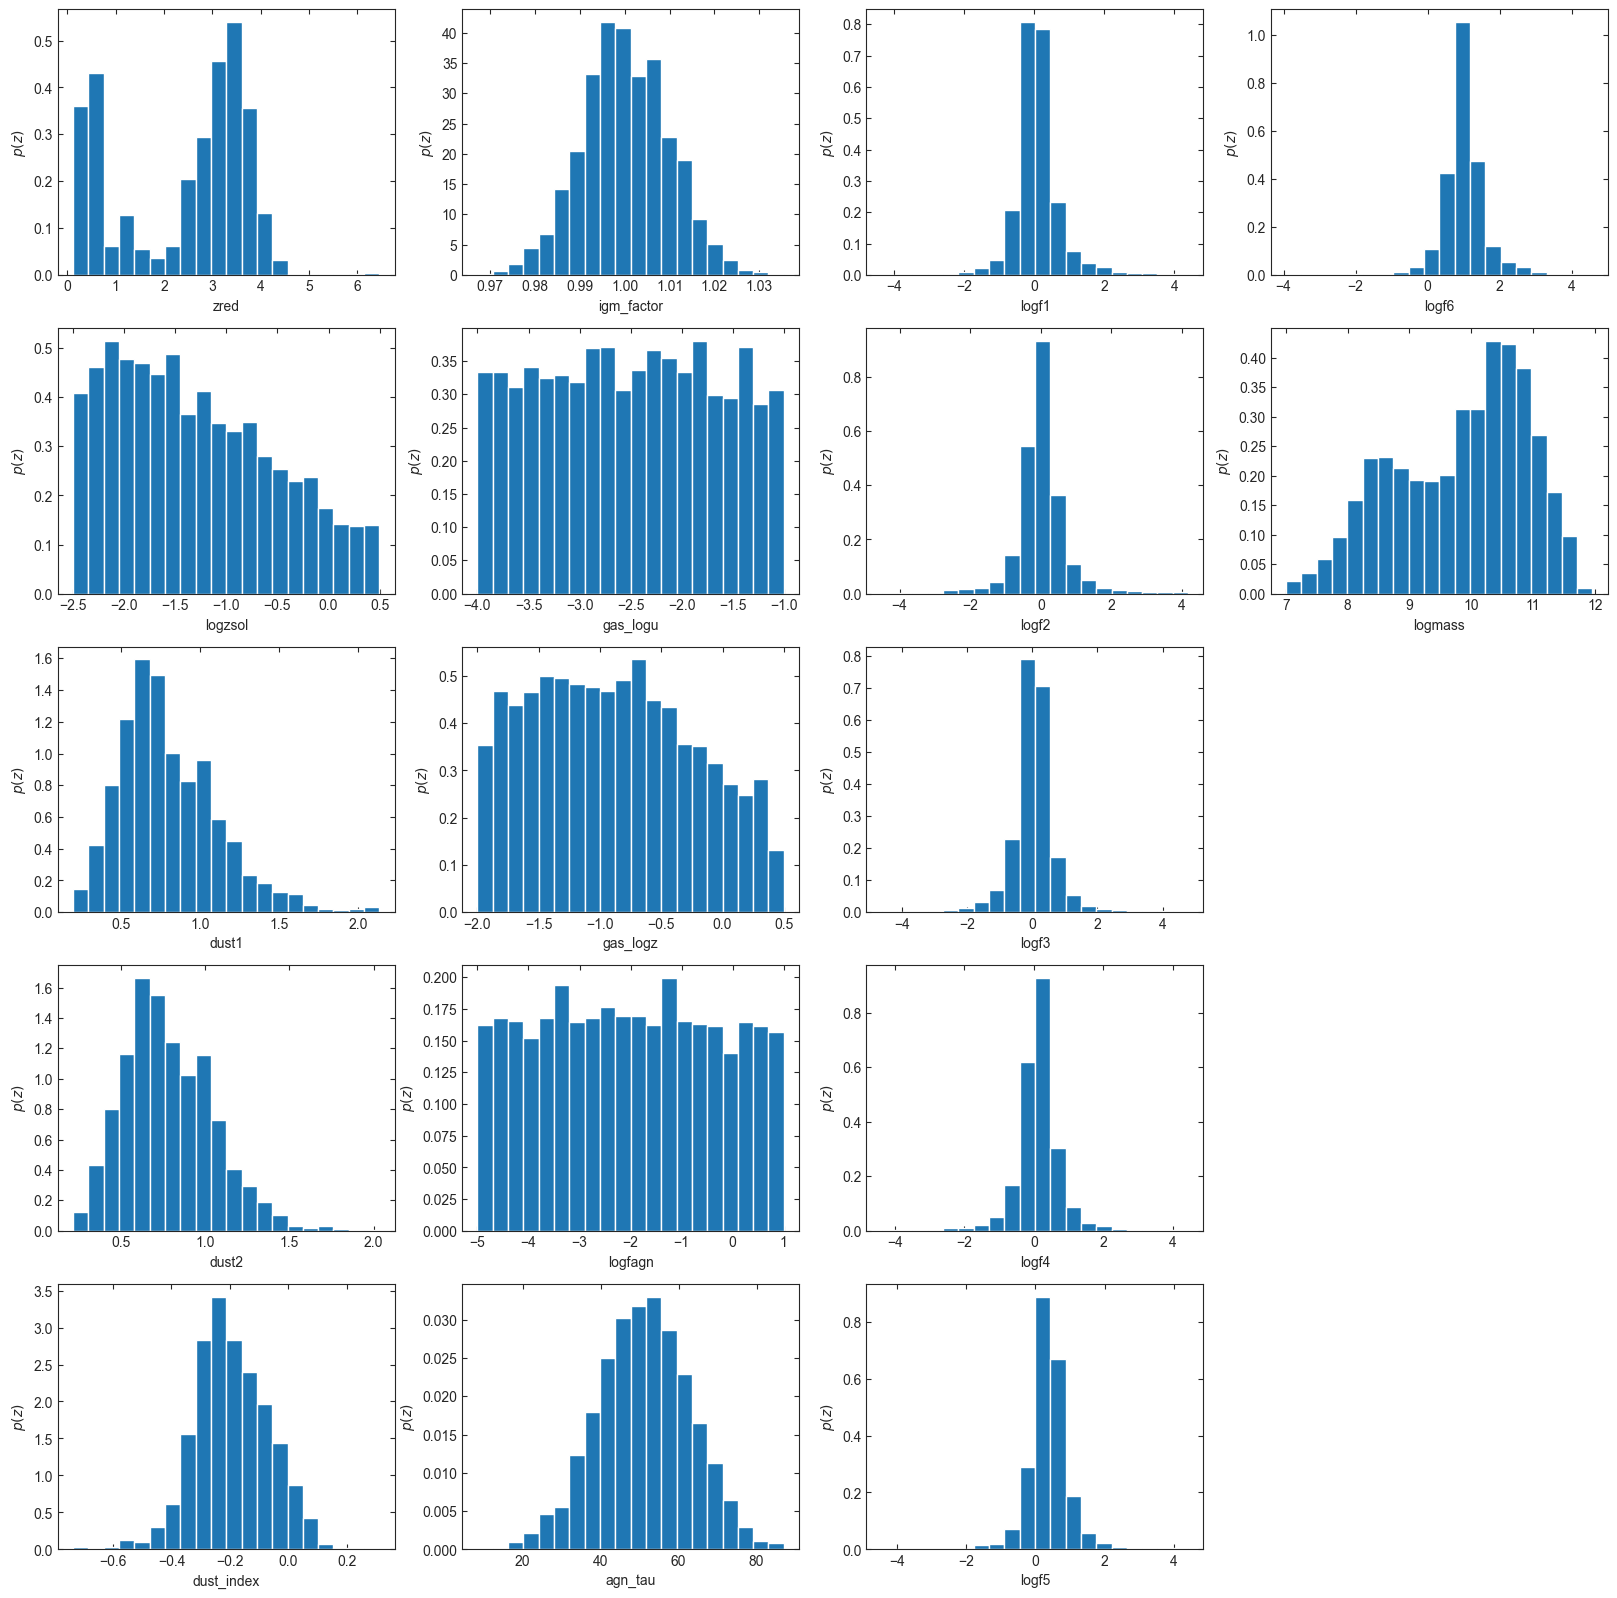

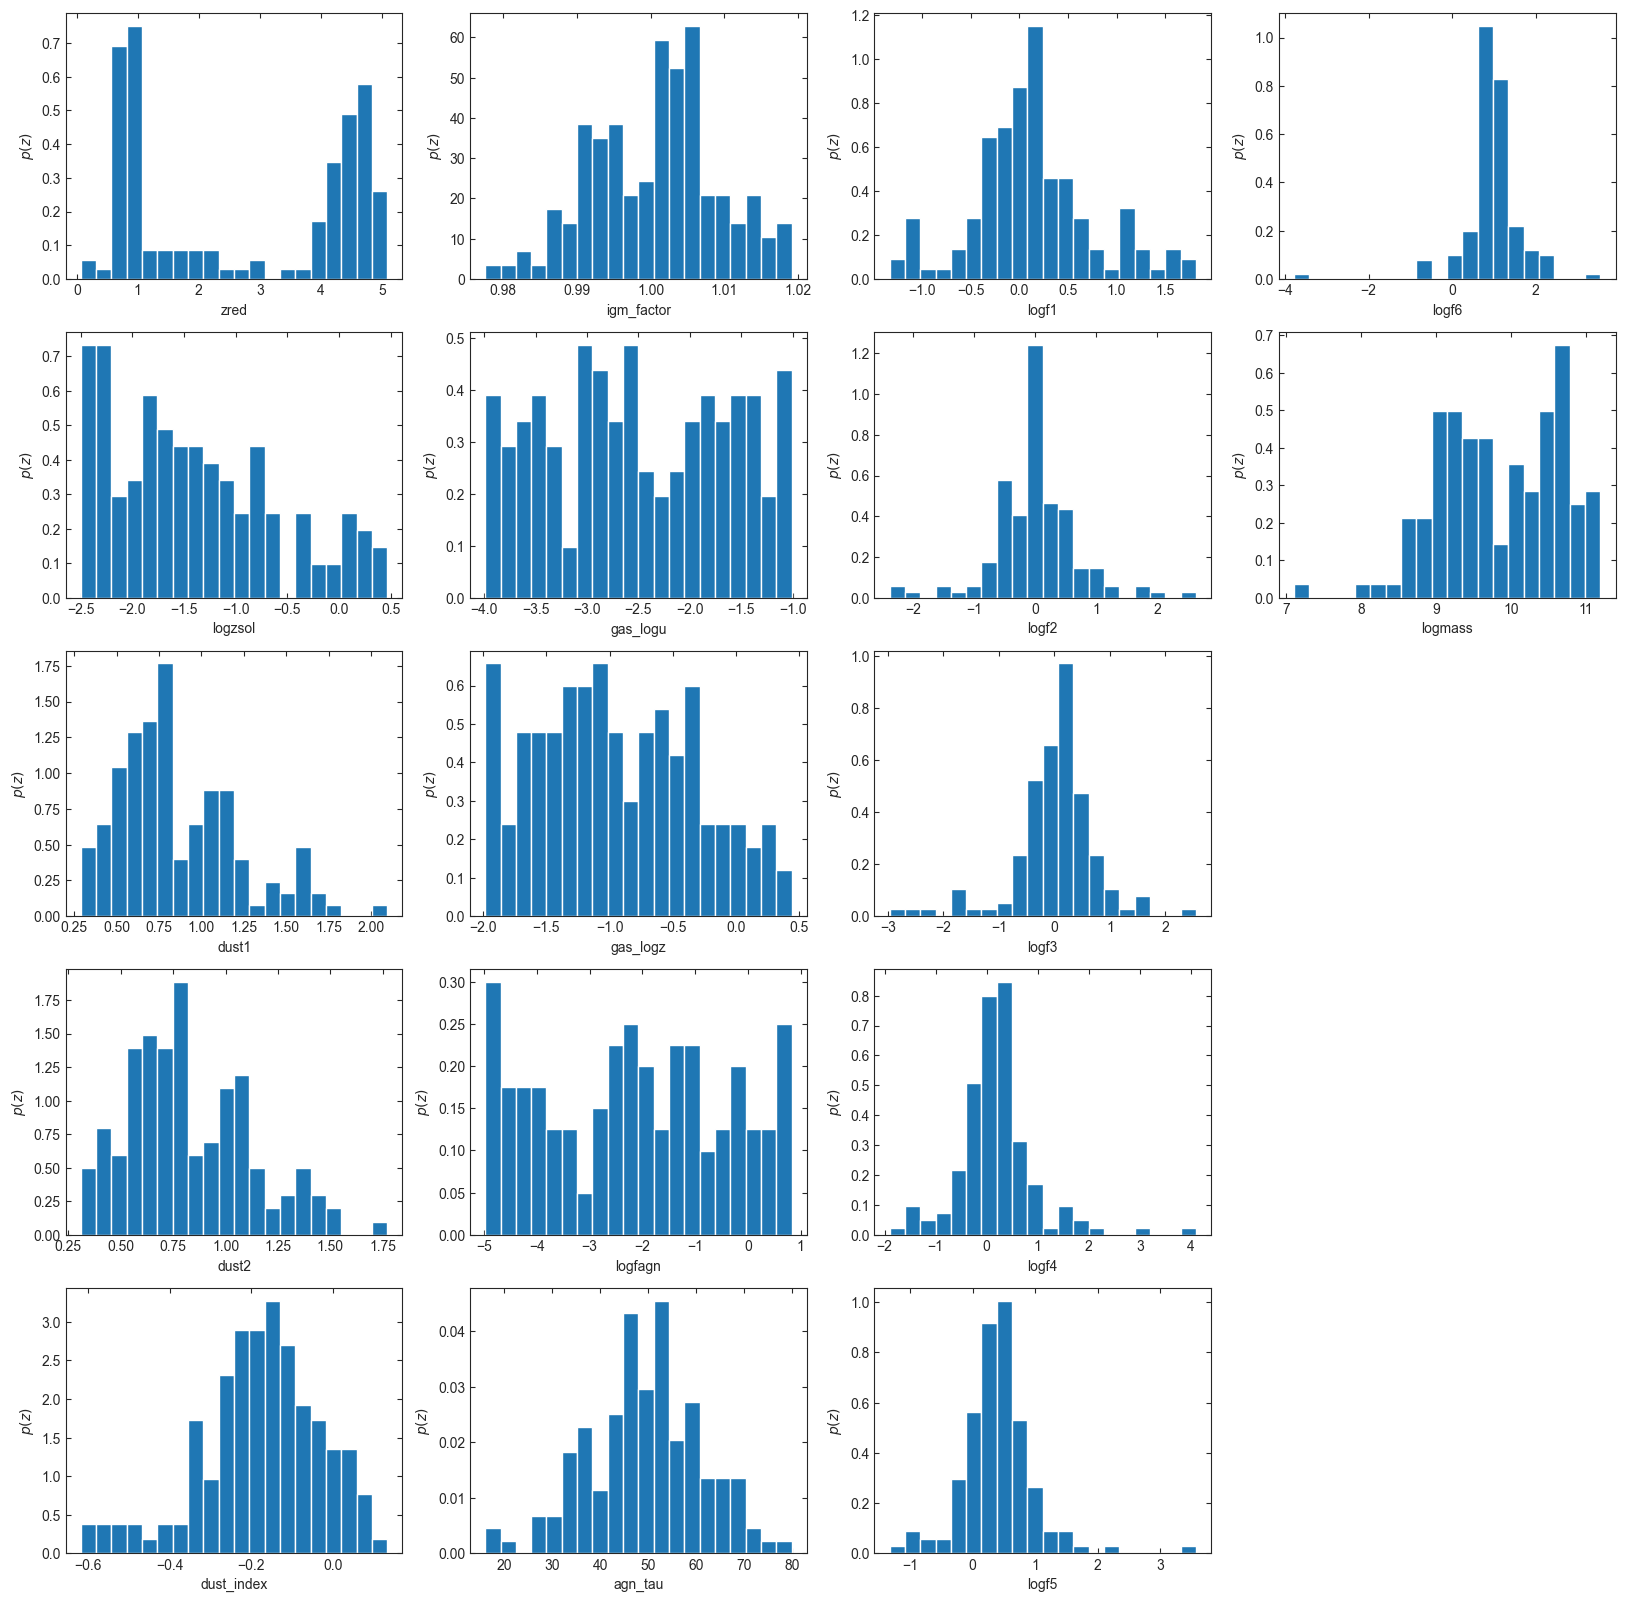

In [6]:
indx=np.random.randint(0, nzs.shape[0])
pop.plot_galaxy_population(spsp[indx])
pop.plot_galaxy_population(np.squeeze(selected_spsp[indx, 0]))
pop.plot_galaxy_population(np.squeeze(selected_spsp[indx, 1]))
pop.plot_galaxy_population(np.squeeze(selected_spsp[indx, 2]))

u-dropout Interloper Fraction: 33.01994743717697 +/- 3.9298338848646086
g-dropout Interloper Fraction: 31.750313582240317 +/- 4.758256097917574
r-dropout Interloper Fraction: 34.509085441742286 +/- 8.089819070952744


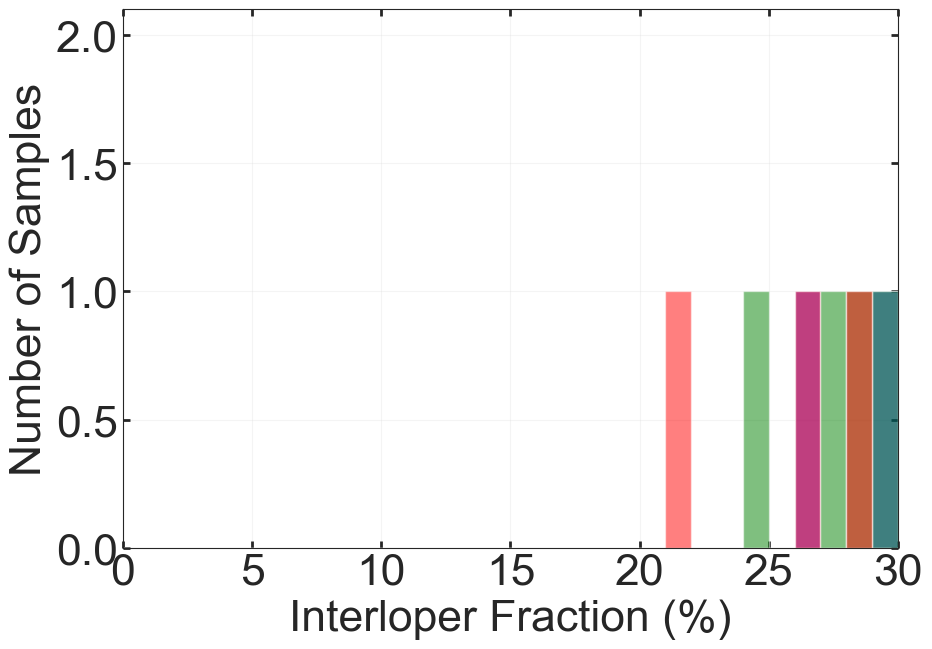

In [7]:
def interlopers(samples):
    nint = len(np.where(samples<1.5)[0])
    ntot = len(samples)
    return (nint/ntot)*100

f, ax = plt.subplots(1, 1, figsize=(10, 7))

uints = []
gints = []
rints = []
for n in range(nzs.shape[0]):
    uints.append(interlopers(nzs[n][0]))
    gints.append(interlopers(nzs[n][1]))
    rints.append(interlopers(nzs[n][2]))

nbins = np.arange(0.0, 100, 1)
histogram = ax.hist(uints, alpha=0.5, bins=nbins, color='blue')
histogram = ax.hist(gints, alpha=0.5, bins=nbins, color='green')
histogram = ax.hist(rints, alpha=0.5, bins=nbins, color='red')

uints_mean = np.mean(uints)
uints_std = np.std(uints)
gints_mean = np.mean(gints)
gints_std = np.std(gints)
rints_mean = np.mean(rints)
rints_std = np.std(rints)

print("u-dropout Interloper Fraction:", uints_mean,"+/-",uints_std)
print("g-dropout Interloper Fraction:", gints_mean,"+/-",gints_std)
print("r-dropout Interloper Fraction:", rints_mean,"+/-",rints_std)

ax.set_xticks(np.arange(0, 35, 5))

ax.set_xlim(0, 30)
ax.grid(alpha=0.2)
ax.set_xlabel("Interloper Fraction (%)", fontsize=32)
ax.set_ylabel("Number of Samples", fontsize=32)
ax.tick_params('x', labelsize=32, width=2, size=5, direction='in', top=True)
ax.tick_params('y', labelsize=32, width=2, size=5, direction='in', right=True)

In [8]:
def get_mass_less_8(seleced_sps, real):

    umasses = np.log10(np.squeeze(seleced_sps[real, 0])[:, -1])
    gmasses = np.log10(np.squeeze(seleced_sps[real, 1])[:, -1])
    rmasses = np.log10(np.squeeze(seleced_sps[real, 2])[:, -1])

    umasses8 = umasses[np.where(umasses < 8)[0]]
    gmasses8 = gmasses[np.where(gmasses < 8)[0]]
    rmasses8 = rmasses[np.where(rmasses < 8)[0]]

    upless8 = (len(umasses8)/len(umasses))*100
    gpless8 = (len(gmasses8)/len(gmasses))*100
    rpless8 = (len(rmasses8)/len(rmasses))*100

    return upless8, gpless8, rpless8

per_mass = np.zeros(3)
for indx in range(nzs.shape[0]):
    per_mass+=np.array(get_mass_less_8(selected_spsp, indx))

per_mass/nzs.shape[0]

array([9.49206696, 5.06952423, 1.78215938])

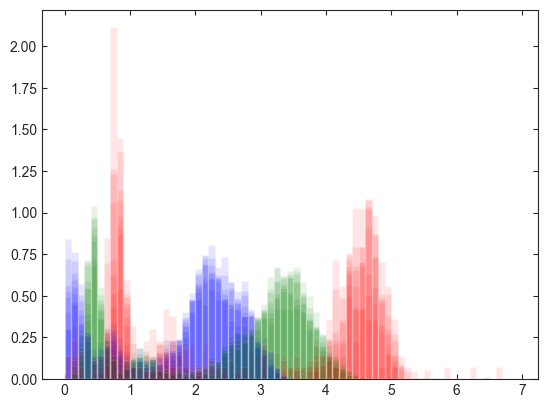

In [9]:
bins = nz.default_nz_bins()

for n in range(nzs.shape[0]):
    hist = plt.hist(nzs[n][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[n][1], density=True, bins=bins, alpha = 0.1, color='green')
    hist = plt.hist(nzs[n][2], density=True, bins=bins, alpha = 0.1, color='red')

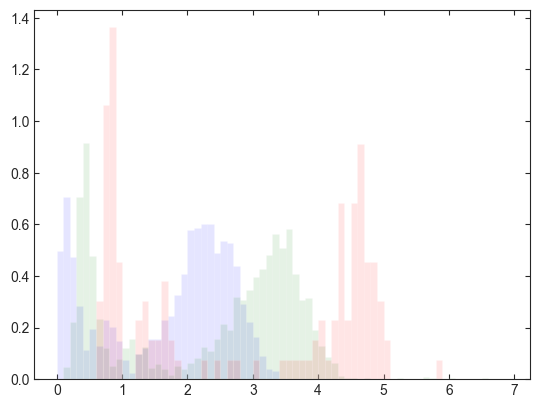

In [10]:
indx=np.random.randint(0, nzs.shape[0])
hist = plt.hist(nzs[indx][0], density=True, bins=bins, alpha = 0.1, color='blue')
hist = plt.hist(nzs[indx][1], density=True, bins=bins, alpha = 0.1, color='green')
hist = plt.hist(nzs[indx][2], density=True, bins=bins, alpha = 0.1, color='red')

In [11]:
#np.save("redshifts/emulated_redshifts_0.npy", nzs)

In [12]:
#np.save("nzs_test2.npy", nzs)
#np.save("spsp_test2.npy", spsp)